# SDOF and MDOF Model Calibration and Compilation

## Introduction

This Jupyter Notebook presents a structured workflow for the calibration and modelling of simplified/idealised structural models in OpenSees, namely single- and multi-degree-of-freedom systems. 

The main applications of this notebook are:

1. **Compile and construct SDOF Models in OpenSees**: Construction of SDOF representations by defining essential structural properties such as mass, height and nonlinear capacity. The first example includes an implementation of nonlinear force-deformation capacity to capture post-elastic behavior powered by OpenseesPy.

2. **Compile and construct MDOF Stick-and-Mass Models in OpenSees**: Construction of MDOF stick-and-mass models, in which each floor is represented as a lumped mass connected by nonlinear springs capturing lateral stiffness and yielding. The second example requires specification of building properties including mass distribution, inter-story stiffness, damping, and nonlinear response characteristics and the implementation of nonlinear force-deformation to capture post-elastic behavior powered by OpenseesPy.

3. **Calibrate and compile MDOF Models Based on SDOF Capacity and Parameters**: The third example aims at establishing consistency between the SDOF and MDOF representations by calibrating inter-story properties of the MDOF model using target capacity curves derived from the SDOF model. Adjustment of parameters such as stiffness, yield strength, and post-yield behavior to ensure that the global capacity of the MDOF model reflects that of the reference SDOF system.

This integrated workflow provides a foundation for both simplified and detailed seismic performance assessment, while demonstrating how calibrated MDOF models can be informed by equivalent SDOF capacities for more accurate regional or portfolio-level evaluations.

---

## References

[1] Lu X, McKenna F, Cheng Q, Xu Z, Zeng X, Mahin SA. An open-source framework for regional earthquake loss estimation using the city-scale nonlinear time history analysis. Earthquake Spectra. 2020;36(2):806-831. doi:10.1177/8755293019891724

## Initialize Libraries ##

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import the classes necessary for structural analysis
from openquake.vmtk.units         import units              # oq-vtmk units class
from openquake.vmtk.modeller      import modeller           # oq-vmtk numerical modelling and analysis module
from openquake.vmtk.calibration   import calibrate_model    # oq-vmtk sdof-to-mdof calibration module

## Example 1: Compiling an SDOF model ##

### Required SDOF Modelling Input Parameters ###

In [2]:
# Number of storeys
number_storeys = 1 # Set to 1 for SDOFs

# Relative floor heights list
floor_height = [2.80]

# Relative floor masses list
floor_mass = [1.0] # Unit mass for SDOFs

# SDOF capacity (First row are Spectral Displacement [m] values - Second row are Spectral Acceleration [g] values)
sdof_capacity = np.array([
                          [0.00060789, 0.00486316, 0.02420000, 0.04353684],   # displacements
                          [0.10315200, 0.20630401, 0.12378241, 0.12502023]    # accelerations
                         ])
# Flag to activate default stiffness-strength degradation and pinching4
sdof_degradation = True

### Compile SDOF Oscillator in OpenSees ###

WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance


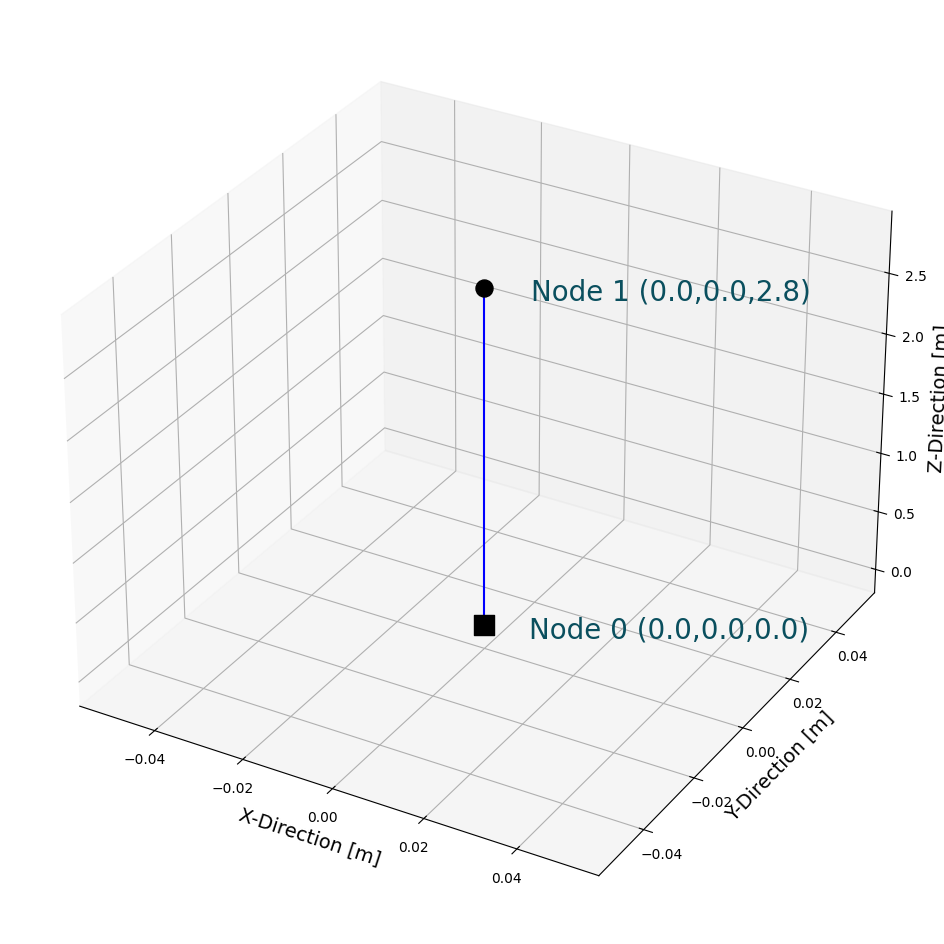

In [3]:
### Compile the SDOF model    
model = modeller(number_storeys,
                 floor_height,
                 floor_mass,
                 sdof_capacity[0, :][np.newaxis, :],          # (1 x 4) displacements
                 (sdof_capacity[1, :]*units.g)[np.newaxis, :],# (1 x 4) accelerations
                 sdof_degradation)                            # Initialise the class (Build the model)
model.compile_model()                                         # Compile the MDOF model    

### View the model
model.plot_model()                           # Visualise the model    

## Example 2: Compiling an MDOF Stick-and-Mass Model ##

### Required MDOF Modelling Input Parameters ###

In [10]:
# Number of storeys
number_storeys = 3 

# Relative floor heights list
floor_heights = [3.00, 3.00, 3.00]

# Relative floor masses list
floor_masses = [1.00, 1.00, 1.00] 

# SDOF capacity (First row are Spectral Displacement [m] values - Second row are Spectral Acceleration [g] values)
# 3 storeys × 4 points each
storey_disps = np.array([
    [0.005, 0.010, 0.020, 0.030],   # storey 1
    [0.006, 0.012, 0.025, 0.035],   # storey 2
    [0.007, 0.014, 0.030, 0.040]    # storey 3
])

storey_forces = np.array([
    [100, 200, 150, 120],  # storey 1
    [120, 240, 180, 140],  # storey 2
    [140, 280, 200, 160]   # storey 3
]) * units.kN   # or *units.g depending on definition

# Flag to activate default stiffness-strength degradation and pinching4
mdof_degradation = True

### Compile MDOF Stick-and-Mass Model in OpenSees ###

WARNING ZeroLength::setDomain(): Element 2000 has L= 3, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 3, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 3, which is greater than the tolerance


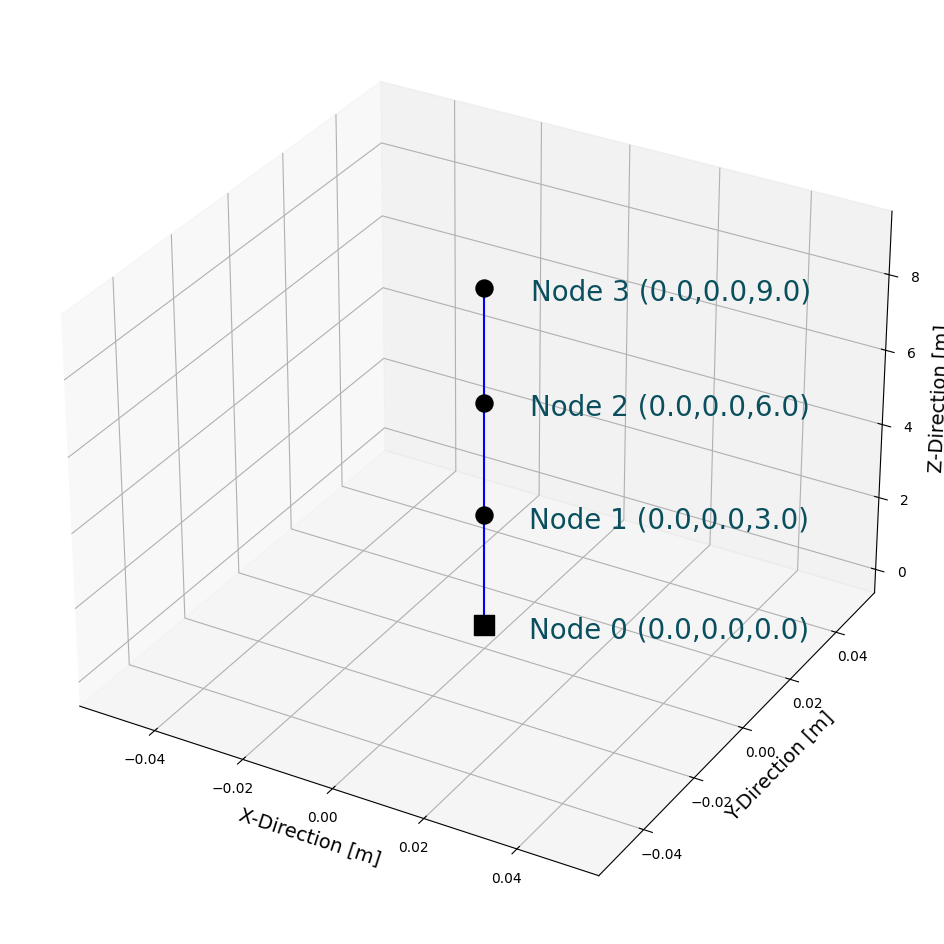

# MODAL ANALYSIS REPORT

* 1. DOMAIN SIZE:
# This is the size of the problem: 1 for 1D problems, 2 for 2D problems, 3 for 3D problems.
3


* 2. EIGENVALUE ANALYSIS:
#          MODE        LAMBDA         OMEGA     FREQUENCY        PERIOD
# ------------- ------------- ------------- ------------- -------------
              1       3961.25       62.9384        10.017     0.0998307
              2       3961.25       62.9384        10.017     0.0998307
              3       31099.2        176.35       28.0669     0.0356292


* 3. TOTAL MASS OF THE STRUCTURE:
# The total masses (translational and rotational) of the structure
# including the masses at fixed DOFs (if any).
#            MX            MY            MZ           RMX           RMY           RMZ
# ------------- ------------- ------------- ------------- ------------- -------------
              3             3         3e-06           126           126         3e-06


* 4. TOTAL FREE MASS OF THE STRUCTURE:
# The total masses (transl

Fundamental Period: T = 0.100 s
Saving figure to modal_summary.png


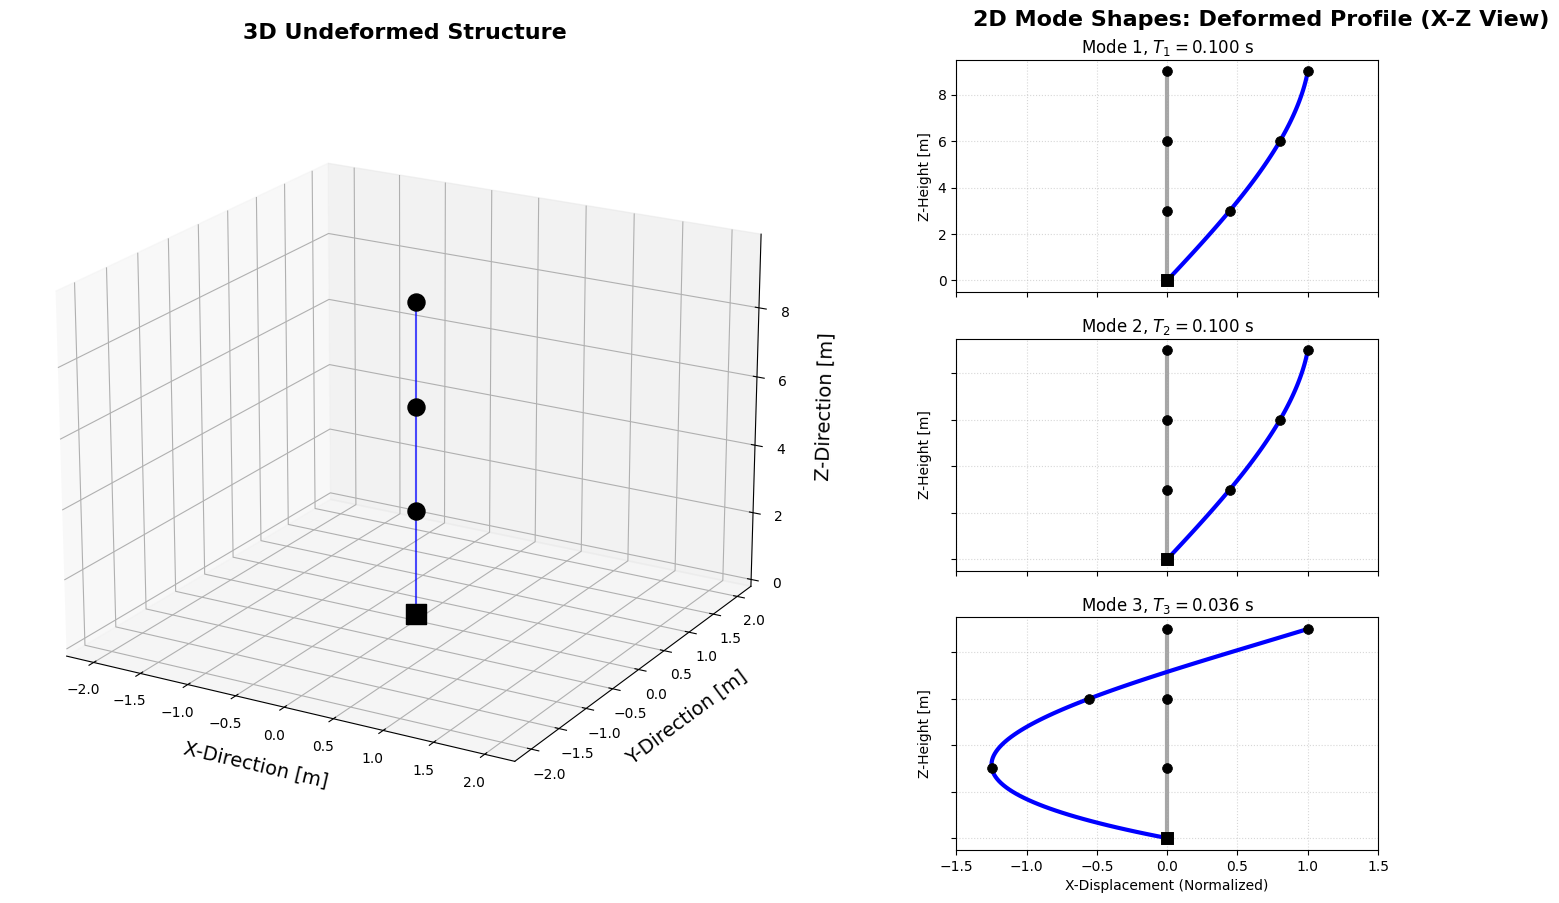

In [12]:
### Compile the SDOF model    
model = modeller(number_storeys,
                 floor_heights,
                 floor_masses,
                 storey_disps,          # (1 x 4) displacements
                 storey_forces,         # (1 x 4) accelerations
                 mdof_degradation)                            # Initialise the class (Build the model)
model.compile_model()                                         # Compile the MDOF model    

### View the model
model.plot_model(export_path = 'model.png')                        # Visualise the model and export figure    

### Perform modal analysis
T, mode_shapes = model.do_modal_analysis(num_modes=3,
                                         pflag=True, 
                                         export_path= 'modal_summary.png')          # Run modal analysis, produce a simplified report and export figure

## Example 3: Calibrating and Compiling an MDOF Stick-and-Mass Model Based on SDOF Capacity ##

### Required SDOF Modelling Input Parameters for MDOF Model Calibration ###

In [6]:
# Number of storeys
number_storeys = 2

# Relative floor heights list
floor_heights = [2.80, 2.80]

# First-mode based participation factor
gamma = 1.33

# SDOF capacity (First row are Spectral Displacement [m] values - Second row are Spectral Acceleration [g] values)
sdof_capacity = np.array([[0.00060789, 0.00486316, 0.02420000, 0.04353684], 
                          [0.10315200, 0.20630401, 0.12378241, 0.12502023]]).T
# Frame flag
isFrame = False

# Soft-storey mechanism flag
isSOS = False

# Degradation flag 
mdof_degradation = True

# Inherent damping 
mdof_damping = 0.05

### Calibrate an MDOF Model based on SDOF Capacity ###

#### The calibration function (calibrate_model) requires five input arguments:
1. Number of storeys
2. First-mode transformation factor (gamma)
3. The capacity array of the single degree-of-freedom oscillator
4. Boolean flag whether the lateral load-resisting system for the considered building class is moment-resisting frames or braced frames (or not)
5. Boolean flag whether the building class expects a soft-storey mechanism to be activated (or not)
#### The calibration function (calibrate_model) returns four output variables:
1. The floor mass array to be assigned to the MDOF model generator (floor_masses)
2. The storey deformation (in m) capacity to be assigned to the MDOF model generator (storey_disps)
3. The acceleration capacity (in g) to be assigned to the MDOF model generator (storey_forces)
4. The considered mode shape (mdof_phi)

The mass of each floor (in tonnes): [0.5979496788391293, 0.448462259129347]
The first-mode shape used for calibration: [0.65138782 1.        ]


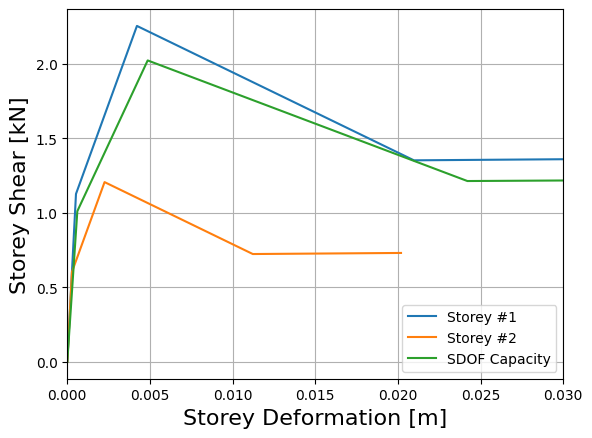

In [7]:
# Calibrate the model using the Lu et al. (2020) method
floor_masses, storey_disps, storey_forces, mdof_phi = calibrate_model(number_storeys, gamma, sdof_capacity, isFrame, isSOS)

print('The mass of each floor (in tonnes):', floor_masses)
print('The first-mode shape used for calibration:', mdof_phi)

# Plot the capacities to visualise the outcome of the calibration
for i in range(storey_disps.shape[0]):
   plt.plot(np.concatenate(([0.0], storey_disps[i,:])), np.concatenate(([0.0], storey_forces[i,:]*9.81)), label = f'Storey #{i+1}')
plt.plot(np.concatenate(([0.0], sdof_capacity[:,0])), np.concatenate(([0.0], sdof_capacity[:,1]*9.81)), label = 'SDOF Capacity')
plt.xlabel('Storey Deformation [m]', fontsize= 16)
plt.ylabel('Storey Shear [kN]', fontsize = 16)
plt.legend(loc = 'lower right')
plt.grid(visible=True, which='major')
plt.grid(visible=True, which='minor')
plt.xlim([0.00, 0.03])
plt.show()

### Compile MDOF Stick-and-Mass Model in OpenSees ###

WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


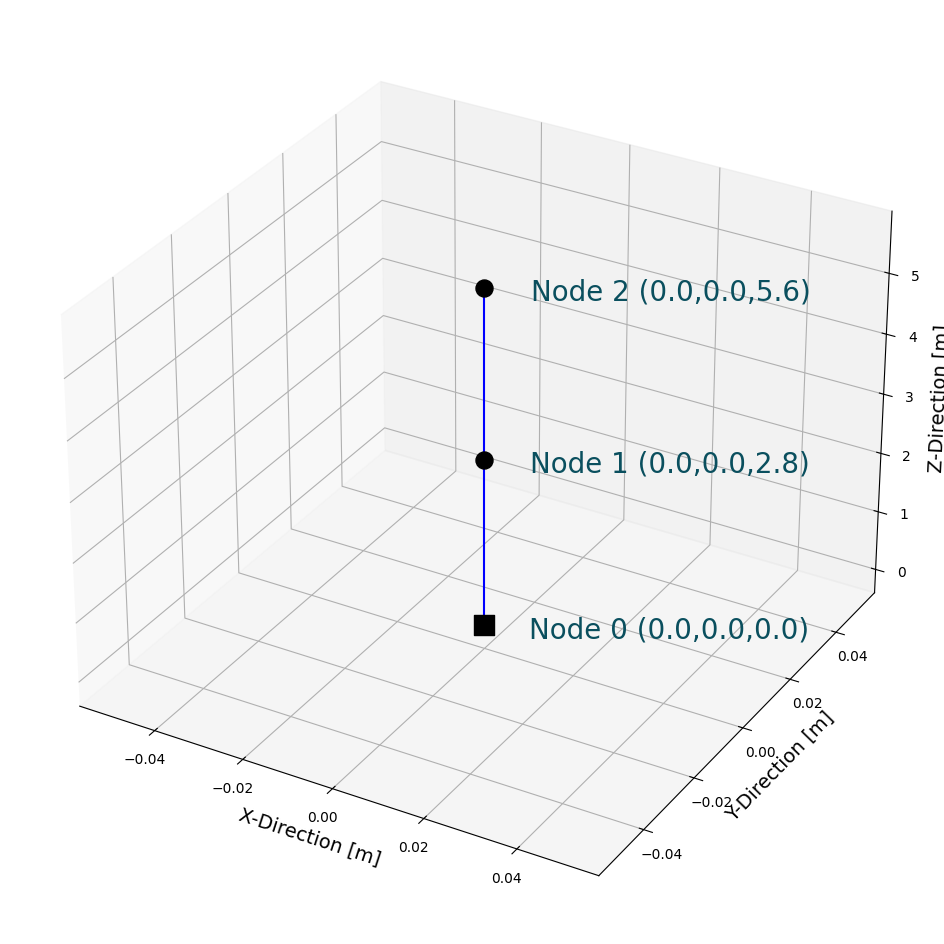

In [8]:
### Compile the SDOF model    
model = modeller(number_storeys,
                 floor_heights,
                 floor_masses,
                 storey_disps,          # (1 x 4) displacements
                 storey_forces,         # (1 x 4) accelerations
                 mdof_degradation)                            # Initialise the class (Build the model)
model.compile_model()                                         # Compile the MDOF model    

### View the model
model.plot_model()                           # Visualise the model      